In [30]:
!nvidia-smi

Tue Mar 25 12:15:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:46:00.0 Off |                    0 |
| N/A   30C    P0             81W /  350W |    1075MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

In [2]:
dev_id = 0
device = torch.device("cuda:"+str(dev_id) if torch.cuda.is_available() else "cpu")

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None,
                     fig_name = "",
                     filetype = ".pdf"):
    
    #Plots training data, tst data and compares predictions 
    
    plt.figure(figsize=(10,7))
    
    #plot taining data in blue
    
    plt.scatter(train_data, train_labels, c="b", s=4, label= "Training Data")
    
    #plot test data in green
    
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")
    
    if predictions is not None:
        
        #plot the predictions in red predictions were maade on the test data)
        
        plt.scatter(test_data,predictions, c="r", s= 4, label= "Predictions")
    
    #Show the legend
    plt.legend(prop={"size":14})
        
    # plt.show()
    plt.savefig(fig_name + filetype) # always save figures

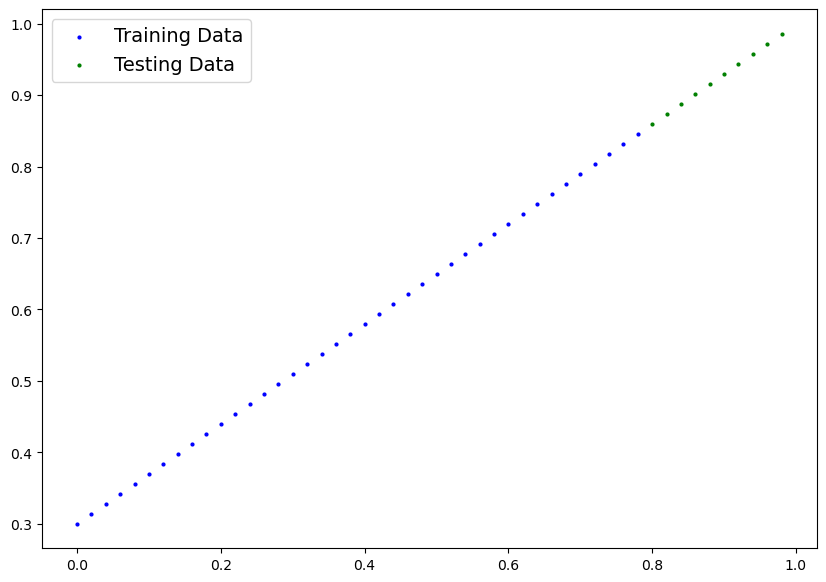

In [6]:
plot_predictions(fig_name="Fig_1", filetype=".jpg")

In [7]:
# Creating a Linear Regression model class
class LinearRegressionModel(nn.Module): 
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1,dtype=torch.float),requires_grad=True) 

        self.bias = nn.Parameter(torch.randn(1,dtype=torch.float),requires_grad=True) 

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.weights * x + self.bias #  linear regression formula 

In [8]:
# Setting manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Creating an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()
model_0.to(device=device)
# Checking the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1288], device='cuda:0', requires_grad=True)]

In [9]:
# Listing named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], device='cuda:0')),
             ('bias', tensor([0.1288], device='cuda:0'))])

In [10]:
# Making predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test.to(device=device))


In [11]:
# Checking predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], device='cuda:0')


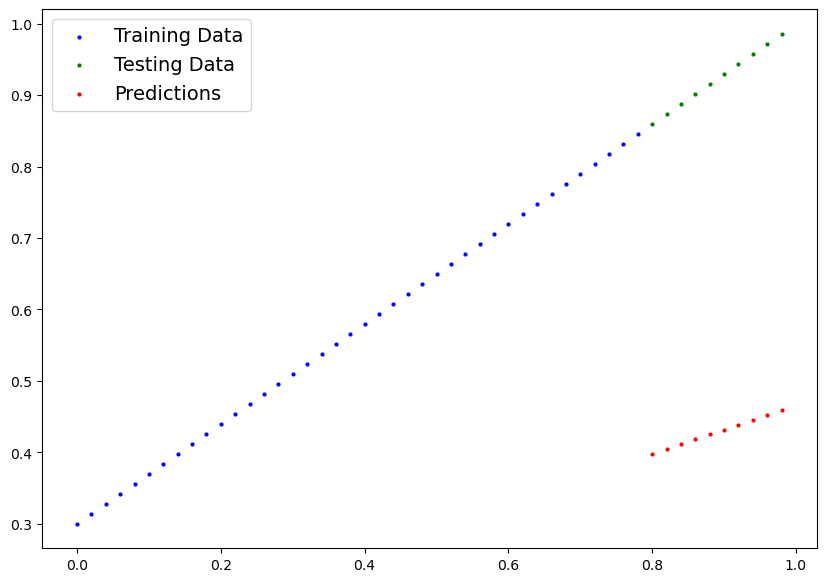

In [12]:
plot_predictions(predictions=y_preds.cpu(),fig_name="Fig_2", filetype=".jpg")

In [13]:
y_test.to(device=device) - y_preds.to(device=device)

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]], device='cuda:0')

In [14]:
# Creating the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Creating the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) # learning rate : higher=more (less stable), lower=less (might take a long time))

In [15]:
epochs = 100

#empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    
    ### TRAINING ###
    
    model_0.train() # putting model in training mode
    
    y_pred = model_0(X_train.to(device=device)) #forward pass on train data using forward() method
    
    loss = loss_fn(y_pred.cpu(), y_train) #Calculating the loss
    
    optimizer.zero_grad() #zero grad of the optimizer
    
    loss.backward() #loss backwards
    
    optimizer.step() #optimizer progression  
    
    
    
    ### TESTING ###
    
    model_0.eval()
    
    with torch.inference_mode():
        
        test_pred = model_0(X_test.to(device=device)) # forward pass on test data
        
        test_loss = loss_fn(test_pred.cpu(), y_test.type(torch.float)) #Calc. loss on test data. | prediction come in torch.float datatype. comparisons needs to be done with tensors of the same type
        
        if epoch % 10 == 0:
            
            epoch_count.append(epoch)
            
            train_loss_values.append(loss.detach().numpy())
            
            test_loss_values.append(test_loss.detach().numpy())
            
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819


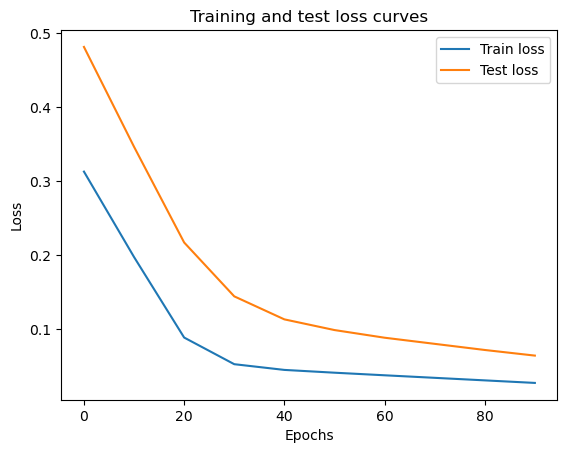

In [16]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig("Fig_3.jpg")  # or "loss_curve_plot.png"


In [17]:
# Finding model's learned parameters
print ( "The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784], device='cuda:0')), ('bias', tensor([0.3513], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [18]:
model_0.eval() #set the model in evaluation mode

with torch.inference_mode(): #setup the inference mode context manager
    
    y_preds = model_0(X_test.to(device=device))
    
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]], device='cuda:0')

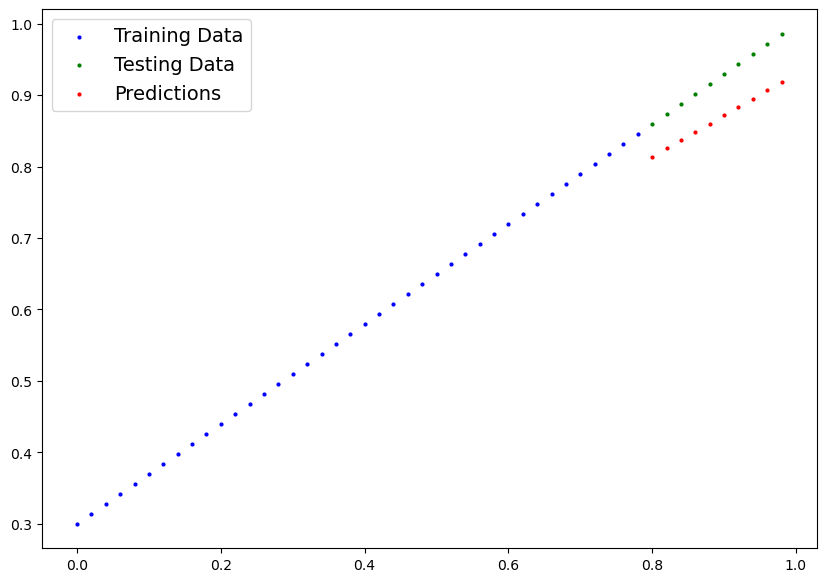

In [19]:
plot_predictions(predictions = test_pred.cpu(), fig_name="Fig_4", filetype=".jpg")

In [20]:
weight = 0.7
bias = 0.3

start = 0 
end = 1
step = .02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y= weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [21]:
train_split = int(.8 *len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

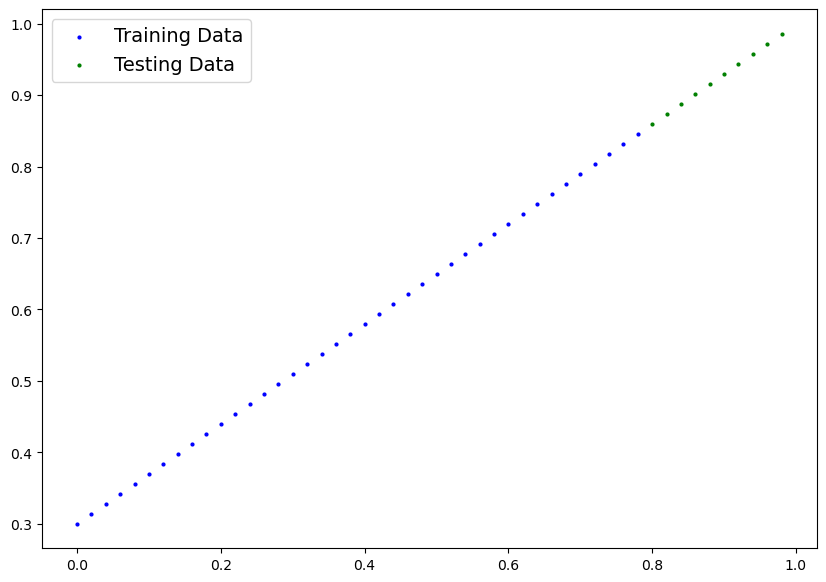

In [22]:
plot_predictions(X_train, y_train, X_test, y_test)


In [23]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
        
    def forward (self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1.to(device=device)
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.8300], device='cuda:0'))]))

In [24]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [25]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params= model_1.parameters(),lr=.01)

In [26]:
torch.manual_seed(42)

epochs = 1000

X_train =X_train.to(device=device)
X_test =X_test.to(device=device)
y_train =y_train.to(device=device)
y_test =y_test.to(device=device)

for epoch in range(epochs):
    model_1.train()
    
    y_pred = model_1(X_train)
    
    loss = loss_fn(y_pred, y_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    
    model_1.eval()
    
    with torch.inference_mode():
        test_pred = model_1(X_test)
        
        test_loss = loss_fn(test_pred, y_test)
        
    if epoch % 100 == 0:
         print(f"Epoch{epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [27]:
from pprint import pprint

print("The model learned the following values for weights and bias: ")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are: ")
print(f"weights: { weight}, bias: {bias}")

The model learned the following values for weights and bias: 
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are: 
weights: 0.7, bias: 0.3


In [28]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

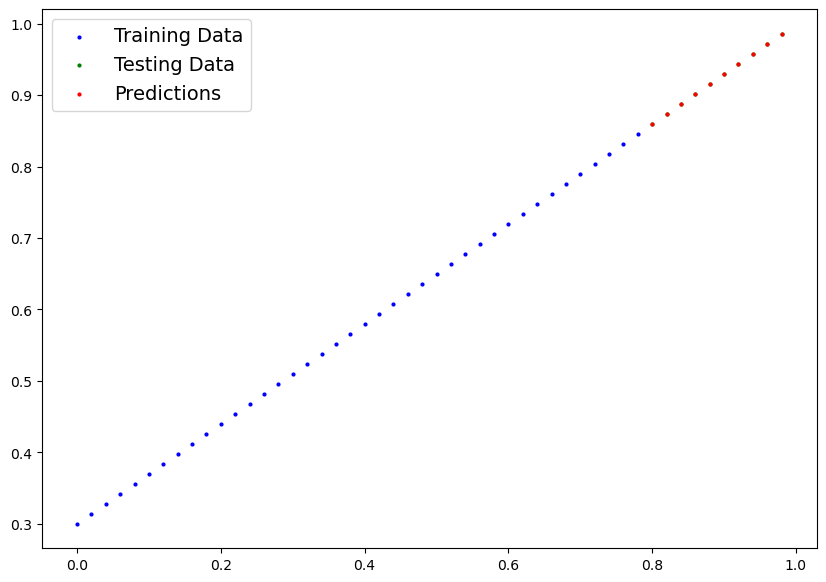

In [29]:
plot_predictions(predictions = y_preds.cpu(),fig_name="Fig_5", filetype=".jpg")